In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 click <a href="javascript:code_toggle()">here</a> to hide the raw code.''')

# 1. Introduction
* **Definition**: Current sheets are geometrically connected structures (usually thin) within which an electric current is confined. Examples of current sheets can be found in the solar heliosphere, solar flares, and other high energy astrophysical systems such as accretion disks. 
* **Motivation**: Current sheets are not only places where magnetic energy dissipated, but also closely related to magnetic reconnection and MHD turbulence which have been recognized as critical to understanding many physical phenomena both on Earth and in space. It is therefore very important to study the properties of current sheets.
* **Method**: We ran large scale MHD simulations in $1000^3$ cube to study the turbulent flow and field. Each snapshot of the 3D cube would be about $\sim 10$ Gbytes which forms the data we are trying to explore. We will apply our feature finding algorithms to identify all the current sheets in the cube.
* **Goal**: the goal is to identify all the sheets, characterize their sizes, and study their properties statistically.

In [2]:
%matplotlib inline
#%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#import athena4_read as ath
import athena_read
from shwave import cn4, cn5
import time

# 2. Data Preparing: construct the current data
## 2.1 load 3d data
The data file is in HDF5 format, and each component of magnetic field has $1000^3$ data points which corresponds to $8$ Gb and takes $50$ seconds to load on a single computer with 512G of RAM and 20 processors called *Tigressdata* at Princeton.

In [8]:
data = athena_read.athdf('Unstra.out2.00008.athdf',quantities=['Bcc1'])
bx = data['Bcc1']
x = data['x1f']; y = data['x2f']; z = data['x3f']
print 'array bx size: ', bx.nbytes/(1024**3), ' Gb'

time =  50.2654835891
array bx size:  8  Gb


In [4]:
data = athena_read.athdf('Unstra.out2.00008.athdf',quantities=['Bcc2'])
by = data['Bcc2']

time =  50.2654835891


In [5]:
data = athena_read.athdf('Unstra.out2.00008.athdf',quantities=['Bcc3'])
bz = data['Bcc3']

time =  50.2654835891


## 2.2 construct current density  $\mathbf{j} = \nabla \times \mathbf{B}$ 
* use cell-centered B with second order accurate central differences gradient to calculate the current density; so the derived j is also on cell center. 

In [6]:
def curl(vx,vy,vz):
  [dzvx,dyvx,dxvx] = np.gradient(vx)
  [dzvy,dyvy,dxvy] = np.gradient(vy)
  [dzvz,dyvz,dxvz] = np.gradient(vz)
  cx = dyvz-dzvy
  cy = dzvx-dxvz
  cz = dxvy-dyvx
  return cx,cy,cz

dx = dy = dz = x[1]-x[0]
jx,jy,jz = curl(bx,by,bz)/dx
j2 = jx**2+jy**2+jz**2

* Show a small section of a slice of the data cube: From left to right, azimuthal field $B_y$, radial component of the current density $j_x$ ($j_x = -\partial_z B_y + ...$), and the magnitude of current density $j$

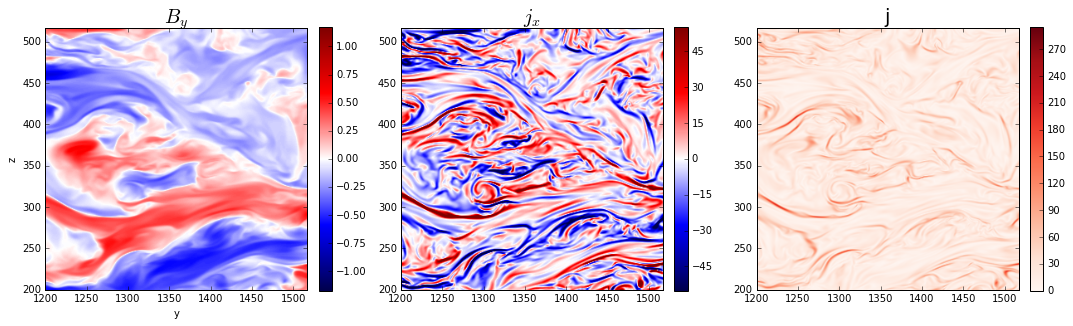

In [7]:
nframe = 1
nplot  = 3
cnt = 1
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fraction=0.046;pad=0.04

xslice = 500
ymin = 1200; ymax=1517 #255
zmin = 200;  zmax=517 #255

vmax = np.max([np.min(by)**2,np.max(by)**2])
vmax = vmax**0.5
vmin = -vmax
plt.subplot(nframe,nplot,cnt)
plt.imshow(by[:,:,xslice],origin='lower',vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.xlabel('y')
plt.ylabel('z')
plt.title(r'$B_y$',size=20)

cnt+=1
vmax = np.max([np.min(jx)**2,np.max(jx)**2])
vmax = vmax**0.5*0.1
vmin = -vmax
plt.subplot(nframe,nplot,cnt)
plt.imshow(jx[:,:,xslice],origin='lower',vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.title(r'$j_x$',size=20)

cnt+=1
jmag = j2**0.5
vmax = np.max(jmag)*0.5
plt.subplot(nframe,nplot,cnt)
plt.imshow(jmag[:,:,xslice],origin='lower',vmin=0,vmax=vmax,cmap='Reds')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.title('j',size=20)

plt.tight_layout()

# the strongest j2 index (for comparison with the 3d struture show below)
#a = j2[:,:,xslice]
#print a.index(max(a))

# 3. search for the current sheet based on $j^2$

## 3.1. find the threshold of $j^2$ above which we define a current sheet
We define the threshold $j_{th}$ by asking $25\%$ of the total dissipation poccesses a current density $j > j_{th}$. The following algorithm uses binary search. 

In [8]:
import time
def estimateJth(j2):
  """
  estimate the j_threshold => 25% of the total 
  ohmic dissipation having j>j_threshold;
  return jth (j_threshold^2)
  """
  j2min=np.min(j2)
  j2max=np.max(j2)
  j2th = 0.5*(j2min+j2max)
  diss4 = np.sum(j2)*0.25
  diss  = np.sum(j2[j2>=j2th])
  epsilon = 0.01
  NMAX  = 100
  count = 0
  while ((np.fabs(1.0-diss/diss4) > epsilon) or (count >=NMAX)):
    count += 1
    if (diss < diss4): # need to lower jth
      j2max = j2th
      j2th = 0.5*(j2min+j2th)
    else:              # need to raise jth
      j2min = j2th
      j2th = 0.5*(j2th+j2max)
    diss = np.sum(j2[j2>=j2th])

  print 'after ',count,' iterations: '
  print 'find threshold current sheet magnitude'
  print 'jth^2 = ',j2th,' 0.25*qdiss_tot = ',diss4,' actual qdiss = ',diss
  return j2th


tstart = time.time()
jth = estimateJth(j2)
tend = time.time()
print 'time cost for estimating jth: ',tend-tstart,' seconds'

after  8  iterations: 
find threshold current sheet magnitude
jth^2 =  10182.3247772  0.25*qdiss_tot =  378655595714.0  actual qdiss =  377503355343.0
time cost for estimating jth:  17.6402509212  seconds


## 3.2. extract locations of individual current sheets with feature finding algorithm
* based on connected-component labeling algorithm
* assuming 1-connectivity (6 cells in 3d), i.e. only the surface-attached cells are counted, no diagonal/corner cells
* only $j^2$ above the threshold is included

In [9]:
import numpy as np
import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology
from discrete_cmap import discrete_cmap
#import discrete_cmap

tstart = time.time()
## jth = 10182.3247772 # threshold for j^2
s=morphology.generate_binary_structure(3,1) # 1: 6-pts connection ; 2: 26(?)-pts connection
data = np.copy(j2)
data[data < jth] = 0.
labeled_array, num_features = measurements.label(data, structure=s)
tend = time.time()
print 'time cost for identifying features: ',tend-tstart,' seconds'
print num_features

time cost for identifying features:  14.697491169  seconds
230914


* sort and store each current sheet a dictionary which consists cell location in the cube and current density magnitude as key and value. The whole set of current sheets form a list.  

In [10]:
from collections import defaultdict
tstart = time.time()
whole_dict =defaultdict(list)
whole_cond = np.argwhere(labeled_array > 0)

#cond = (labeled_array == 1000).nonzero()
tmid = time.time()
for loc in whole_cond:
  #whole_dict[(loc[0],loc[1],loc[2])] = j2[loc[0],loc[1],loc[2]]
  whole_dict[labeled_array[loc[0],loc[1],loc[2]]].append([(loc[0],loc[1],loc[2]),j2[loc[0],loc[1],loc[2]]])
#allkeys = [(loc[0],loc[1],loc[2]) for loc in np.argwhere(labeled_array == 1)]
#alldata = [j2[loc[0],loc[1],loc[2]] for loc in np.argwhere(labeled_array == 1)]
#ndict = dict(zip(allkeys,alldata))
tend = time.time()
print 'time cost: ',tend-tstart,' seconds'
print 'time cost for argwhere = ', tmid-tstart
#j2[loc[0],loc[1],loc[2]]

time cost:  71.3487892151  seconds
time cost for argwhere =  5.53142499924


In [11]:
tstart=time.time()
jlist = []
for i in range(1,num_features):
  jsheet={}
  for item in whole_dict[i]:
    jsheet[item[0]] = item[1]
  if jsheet:
    jlist.append(jsheet)
    
tmid = time.time()
# sort the list based on length
jlist_sorted = sorted(jlist,key= lambda sheet: -len(sheet))  
tend = time.time()
print 'time cost for populating =: ',tmid-tstart,' seconds'
print 'time cost for sorting    = ', tend-tmid,' seconds'
print 'first top 5 largest sheets: ',[len(jlist_sorted[i]) for i in range(0,5)]
print '# of sheets poccess more than 10 cells: ', [i for i in range(num_features-1) if (len(jlist_sorted[i]) >= 10)][-1]


time cost for populating =:  14.4376769066  seconds
time cost for sorting    =  0.136938095093  seconds
first top 5 largest sheets:  [849028, 767373, 418203, 321823, 318330]
# of sheets poccess more than 10 cells:  33509


# 4. Visualization of current sheets 
## 4.1. the top 9 sheets (interactive scattering plots)
Here we use the scattering plots to show the general structures of a few largest sheets identified in our data. THe numbers listed on top left are total grid points (cells) in given current sheet.

<IPython.core.display.Javascript object>


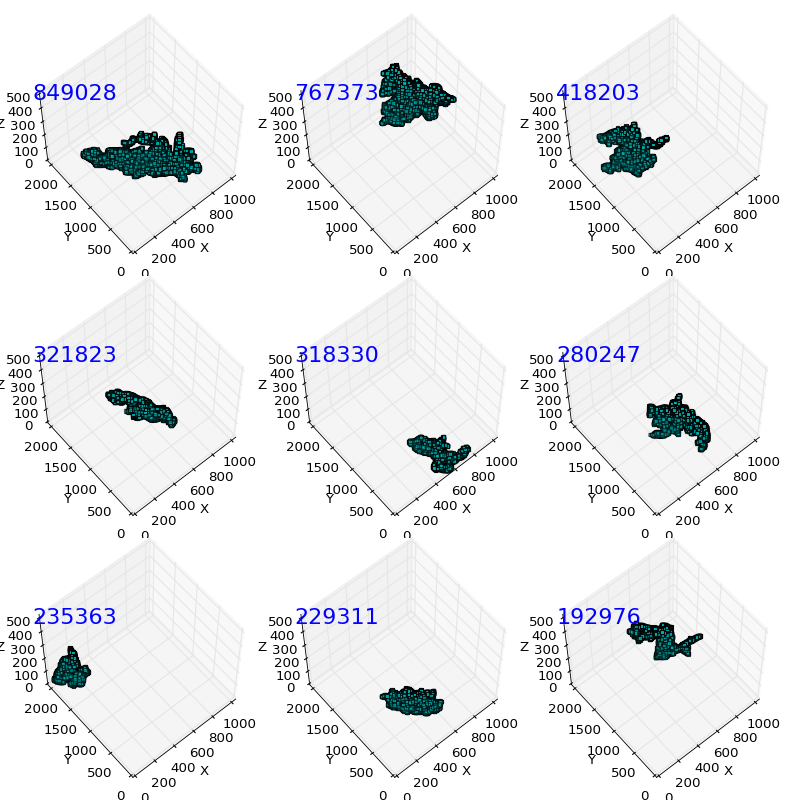

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook
#show the first six sheets largest in size
nframe = 3
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (10, 10.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04
xlim = 1024
ylim = 2048
zlim = 512
stride = 10
gs = gridspec.GridSpec(3, 3)
for i in range(0,9):
  locs = np.array(jlist_sorted[i].keys())
  nlocs = len(locs[:,0])
  ax = fig.add_subplot(gs[i], projection='3d')
  ax.scatter(locs[0:nlocs:stride,2], locs[0:nlocs:stride,1], locs[0:nlocs:stride,0],marker='s',c='c',s=10)
  #ax.plot_surface(locs[:,2], locs[:,1], locs[:,0],rstride=5,cstride=5,color='k')
  #ax.plot_wireframe(locs[:,2],locs[:,1],locs[:,0],rstride=20,
  #                     cstride=20,
  #                     color='DarkSlateBlue',
  #                     linewidth=1,
  #                     antialiased=True)
  ax.set_xlim3d(0, xlim-1)
  ax.set_ylim3d(0, ylim-1)
  ax.set_zlim3d(0, zlim-1)

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.text(-100, ylim, zlim, str(nlocs), zdir=None,color='b',size=20)
  ax.view_init(elev=60, azim=230)

plt.tight_layout()


## 4.2 Visualize a single sheet with details
* take the eighth largest sheet for example, we draw the sheet itself with color coded current density, we also draw the projections of the sheet onto the cube surfaces as shown in color.

(229311, 3)
155143.793413 10182.5266668


<IPython.core.display.Javascript object>


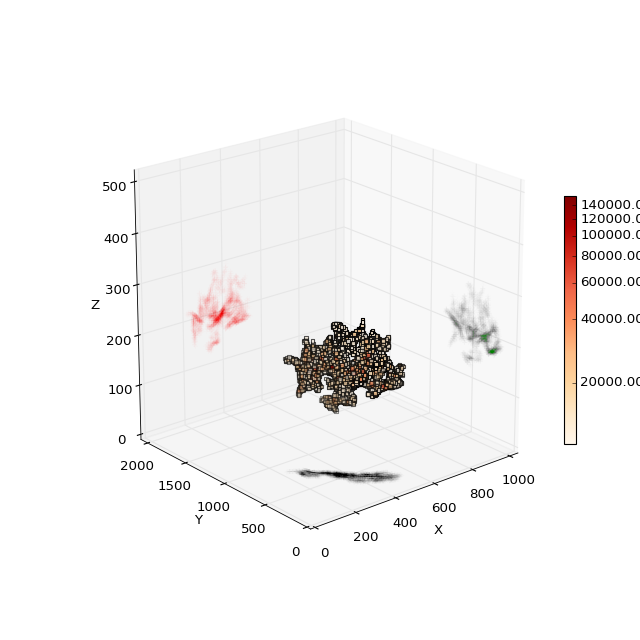

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare grid points with sheet found above
jsheet = jlist_sorted[7]
locs = np.array(jsheet.keys())  
print locs.shape
nlocs = len(locs[:,0])
stride = 20
xlim = 1024
ylim = 2048
zlim = 512
cs = (np.array(jsheet.values())[0:nlocs:stride])
print max(cs),min(cs)

#
# create a mappable colormap based on the value of j^2 in log scale
#
#cNorm = matplotlib.colors.Normalize(vmin=np.min(cs), vmax=np.max(cs))
cNorm = matplotlib.colors.LogNorm(vmin=np.min(cs), vmax=np.max(cs))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('OrRd'))
#print scalarMap.to_rgba(cs)



# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=0 #-0.1
ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
ax.scatter(locs[0:nlocs:stride,2], locs[0:nlocs:stride,1], locs[0:nlocs:stride,0],marker='s',s=10,c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
# fiddling with the color-bar
cb=fig.colorbar(scalarMap,fraction=fraction,pad=pad,orientation='vertical',format='%.2f')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()

# add 2d projections
ax.plot(locs[0:nlocs:stride,2], locs[0:nlocs:stride,0], 'r+', zdir='y', zs=ylim, alpha=0.005)
ax.plot(locs[0:nlocs:stride,1], locs[0:nlocs:stride,0], 'g+', zdir='x', zs=xlim, alpha=0.005)
ax.plot(locs[0:nlocs:stride,2], locs[0:nlocs:stride,1], 'k+', zdir='z', zs=0., alpha=0.005)


ax.set_xlim3d(0, xlim)
ax.set_ylim3d(0, ylim)
ax.set_zlim3d(0, zlim) #255)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=230) 

# 5. Dimensions of current sheets

## 5.1.  dimensions of single current sheet ($\lambda,\xi,l$)  
* Apply the Principle Component Analysis (PCA) on one single sheet, determine first three componet vectors which are orthogonal to each other. Again we take the eighth largest sheet as an example.

In [14]:
from sklearn.decomposition import PCA
# prepare grid points with sheet found above
jsheet = jlist_sorted[7]
locs = np.array(jsheet.keys()) 

pca = PCA(n_components=3)
pca.fit(locs)
#PCA(copy=True, n_components=3, whiten=False)
print(pca.components_) 
print locs.shape

[[-0.01432627 -0.91528103  0.40256104]
 [-0.8827452  -0.17751756 -0.43502694]
 [ 0.46963356 -0.36159114 -0.80541677]]
(229311, 3)


* Now with pca.components $\mathbf I_i$, calculate the geometrical size ($\lambda,\xi,l$) as follows:

 (1) define the projected distance of a grid point $\mathbf{x_j}$ onto $\mathbf{I_i}$ as $d_{ij} = \mathbf{x_j}\cdot \mathbf{I_i}\, /\, ||\mathbf{I_i}||$
 <br>
 (2) define the length $\lambda$, width $\xi$, height $l$ as the difference between the largest and the smallest $d_{ij}$ for the 1st, 2nd and 3rd components 
 


We found for this given sheet, the length, width, and thickness are about 1.5, 0.7, and 0.25 respectively, which indicates a prolate shape.

In [15]:
# calc x\cdot I_1
#print len(locs[:,0])
iz = locs[:,0]; iy = locs[:,1]; ix = locs[:,2]
i1 = pca.components_[0]; i2= pca.components_[1]; i3 = pca.components_[2]
d1 = np.array([locs[i,:].dot(i1) for i in range(0,len(locs[:,0]))])
d2 = np.array([locs[i,:].dot(i2) for i in range(0,len(locs[:,0]))])
d3 = np.array([locs[i,:].dot(i3) for i in range(0,len(locs[:,0]))])

# dimensions of the sheet
L1 = max(d1)-min(d1)
L2 = max(d2)-min(d2)
L3 = max(d3)-min(d3)
dx = x[1]-x[0]

print 'dimensions of the example sheet: ({:5.2f},{:5.2f},{:5.2f}) {}'.format(L1*dx,L2*dx*2,L3*dx, ' H')



dimensions of the example sheet: ( 1.47, 0.66, 0.25)  H


## 5.2  $(\lambda,\xi,l)$ for all current sheets
We include the calculation of the dissipation as well. 
* we ask our current sheets to have at least 30 gird points in order to perform a sensible PCA. Essentially, we could do stability test for the small size sheets to tell if a viable PCA is achieved. 
* To expedite the PCA for all sheets, we make use of multiprocessing to spawn parallel jobs. 

In [9]:
from sklearn.decomposition import PCA
import multiprocessing as mp
from itertools import product
import time




nlist = len(jlist_sorted)
pca = PCA(n_components=3)

# only consider sheet with more than 30 grid points
nlist = np.max([i for i in range(nlist) if len(jlist_sorted[i])>29])

# allocate list for storage 
#jmax = []; diss = []; size = []; ncells = []
eta = 1.0; dx = x[1]-x[0]; dv = dx**3

def dimensions_jsheet(num):
  js = jlist_sorted[num]
  #print num
  #print len(jlist_sorted[num])
  locs = np.array(js.keys()) 
  if (len(locs[:,0])<30):
    print 'reach <30'
    return [0,0,0,(0,0,0)]
  else:
# num of cells in given sheet
    ncell = len(js)
# find j_max
    maxj = np.max(np.array(js.values()))
    #jmax.append(maxj)
    #print jmax
# compute dissipation \epsilon
    eps  = np.sum(eta*np.array(js.values()))*dv
    #diss.append(eps)
    #print diss
# compute (lambda,xi,l)
    #pca.fit(locs)
    pca = PCA(n_components=3).fit(locs)
    i1 = pca.components_[0]; i2= pca.components_[1]; i3 = pca.components_[2]
    d1 = np.array([locs[i,:].dot(i1) for i in range(0,len(locs[:,0]))])
    d2 = np.array([locs[i,:].dot(i2) for i in range(0,len(locs[:,0]))])
    d3 = np.array([locs[i,:].dot(i3) for i in range(0,len(locs[:,0]))])
    # dimensions of the sheet
    L1 = np.max([dx*(max(d1)-min(d1)),dx])
    L2 = np.max([dx*(max(d2)-min(d2)),dx])
    L3 = np.max([dx*(max(d3)-min(d3)),dx])
    return [ncell,maxj,eps,(L1,L2,L3)]

#create a pool and map the target function with multi-arguments
tstart = time.time() 

npr = 8
p = mp.Pool(processes=npr)
result = p.map(dimensions_jsheet,range(nlist),chunksize=npr)

p.close()
p.join()

tend = time.time()
print 'time spent with ',str(npr), ' processors = ', tend-tstart, ' seconds'



ncells = [result[i][0] for i in range(nlist)]
jmax   = [result[i][1] for i in range(nlist)]
diss   = [result[i][2] for i in range(nlist)]
size   = [result[i][3] for i in range(nlist)]

print 'number of sheets with more than 30 cells = ', len(size)

      

time spent with  8  processors =  30.2479219437  seconds
number of sheets with more than 30 cells =  18298


# 6. Some statisitics about current sheets

## 6.1 histogram of $j_{max}$, $\epsilon$, and sizes for all sheets

* From the distribution, we find that most of the sheets have length $\sim 0.3H$ and width about $\sim 0.1 H$, and thickness of about 2 grid cells, indeed very thin.

* The distribution of maximum current density scales as $j_{max}^{-4}$ steeply indicating a $j_{max}$ cutoff exists

* The distribution of dissipated energy within given sheet drops almost linearly with increasing $\epsilon$.

* The distribution of sheet averaged current density is narrowly distributed above the threshold value.

<IPython.core.display.Javascript object>


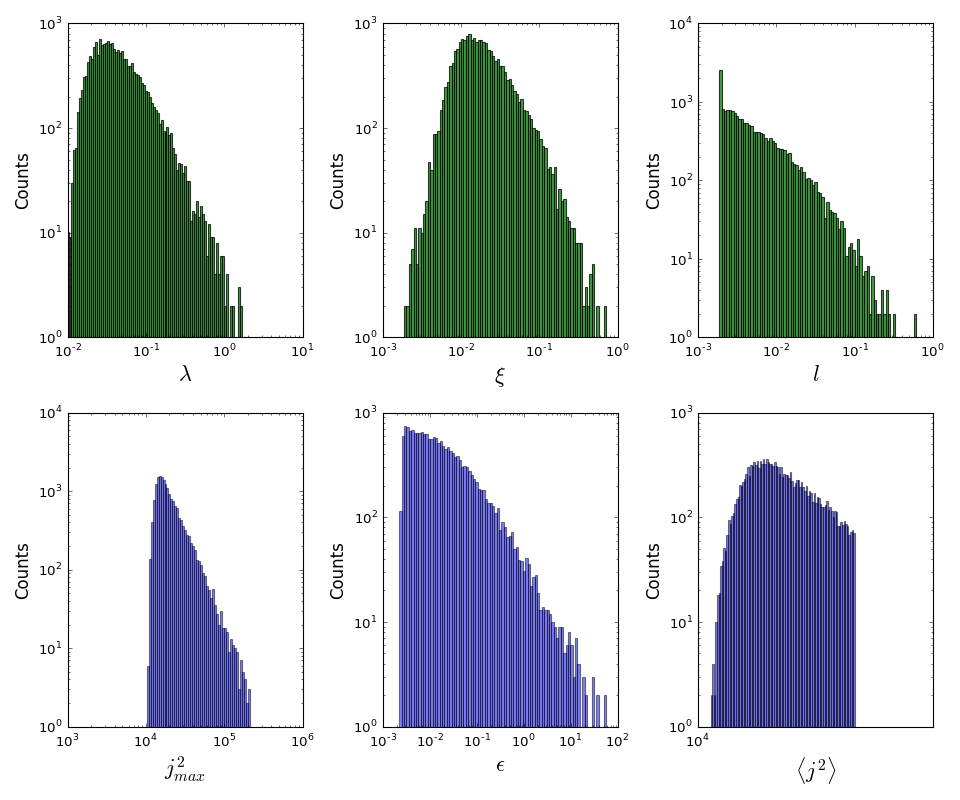

In [10]:
import matplotlib.gridspec as gridspec
%matplotlib notebook

jth=10182.3247772
#print size
nframe = 2
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (12, 15.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04
gs = gridspec.GridSpec(2, 3)
for i in np.arange(6):
  if (i==0):
    hdata = np.array(size)[:,0]
    vmin=-2; vmax=0.5  #in log10
    nbins = 100
    xlab = r'$\lambda$'
  if (i==1):
    hdata = np.array(size)[:,1]
    vmin=-3;vmax=0
    nbins = 100
    xlab = r'$\xi$'
  if (i==2):
    hdata = np.array(size)[:,2]
    vmin=-3;vmax=0
    nbins = 100
    xlab = r'$l$'
  if (i==3):
    hdata = jmax
    vmin = 3; vmax = 5.5
    nbins=100
    xlab = r'$j^2_{max}$'
  if (i==4):
    hdata = diss
    vmin = -3; vmax=2
    nbins = 100
    xlab = r'$\epsilon$'
  if (i==5):
    hdata = np.array(diss)/np.array(ncells)/dv #/((x[1]-x[0])**3)
    vmin = 4; vmax = 4.2
    nbins = 100
    xlab = r'$\langle j^2\rangle$'
    
 
  fig.add_subplot(gs[i])
  if (i< 3): 
    n, bins, patches = plt.hist(hdata, bins=np.logspace(vmin,vmax,nbins), normed=False, facecolor='green', alpha=0.75)
    plt.text(vmin,7000,'total counts: '+str(len(hdata)),size=20,color='g')
  else:
    n, bins, patches = plt.hist(hdata, bins=np.logspace(vmin,vmax,nbins), normed=False, facecolor='blue', alpha=0.5)
     
  plt.xlabel(xlab,size=20)
  plt.ylabel('Counts',size=15)
  plt.gca().set_xscale("log")
  plt.gca().set_yscale("log",nonposy='clip')
  if(i==5):
    plt.xlim([1e4,10**4.3])
 
plt.tight_layout()

## 6..2 Correlation analysis
In the plot below, we explore the correlation among current sheet aspect ratio $\lambda/\xi$ (length/width), maximum current density $j_{max}$, volume averaged dissipation rate $\langle\epsilon\rangle$, and number of cells $N$ (volume) for all sheets.  We plot the correlation between $j_{max}$ (in x-axis) and $\langle\epsilon\rangle$ (in y-axis), the color shows the aspect ratio while the size of the bubble shows the $N^{1/2}$.

The bubble chart below shows us:

* There is a strong positive correlation between $j_{max}$ and $\langle\epsilon\rangle$, current sheet that holds greater peak values of current density in general also has stronger volume averaged dissipation.

* current sheet that holds greater peak current density values also tend to be bigger in size, but not correlated with the extreme elongated shapes.

* bigger current sheets therefore tend to have higher peak current density values and greater dissipation rate. Energetically speaking, they tend to dominate those smaller ones. 



<IPython.core.display.Javascript object>


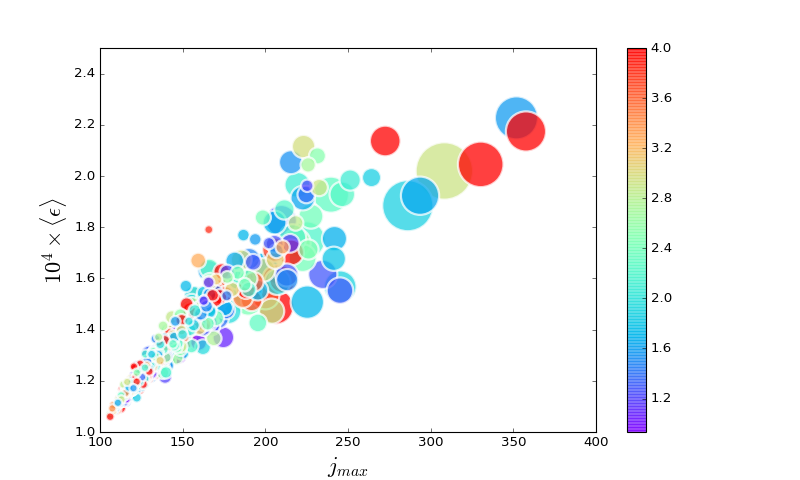

In [43]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 6)

stride = 30
L1 = np.array(L)[0:-1:stride,0]
L2 = np.array(L)[0:-1:stride,1]
L3 = np.array(L)[0:-1:stride,2]
aspect_ratio=L1/L2
cutoff = 4.
aspect_ratio[aspect_ratio>cutoff] =cutoff
energy_density  = np.array(np.array(diss[0:-1:stride])/np.array(ncells[0:-1:stride])/dv)
volume = np.array(ncells[0:-1:stride])
peakj = np.array(jmax)[0:-1:stride]**0.5
cm = plt.cm.get_cmap('rainbow')


# making the scatter plot
sct = plt.scatter(peakj, energy_density*1e-4, c=aspect_ratio, cmap=cm,s=volume**0.5*10, linewidths=2, edgecolor='w')
sct.set_alpha(0.75)

plt.axis([100,400,1,2.5])
plt.xlabel(r'$j_{max}$', fontsize=20)
plt.ylabel(r'$10^4\times\langle\epsilon\rangle$',fontsize=20)
plt.colorbar()
plt.show()

## 6.3 3d correlation of the sheet dimensions
try to fit the 3d ($\lambda$,$\xi$,$l$) space with PCA.

* We find the aspect ratio $\lambda$ : $\xi$ : $l$ = $0.93$ : $0.32$ : $0.15$ $\simeq 6 : 2 : 1$

347556.685212 10354.4055134
466.384683458 10.0


<IPython.core.display.Javascript object>


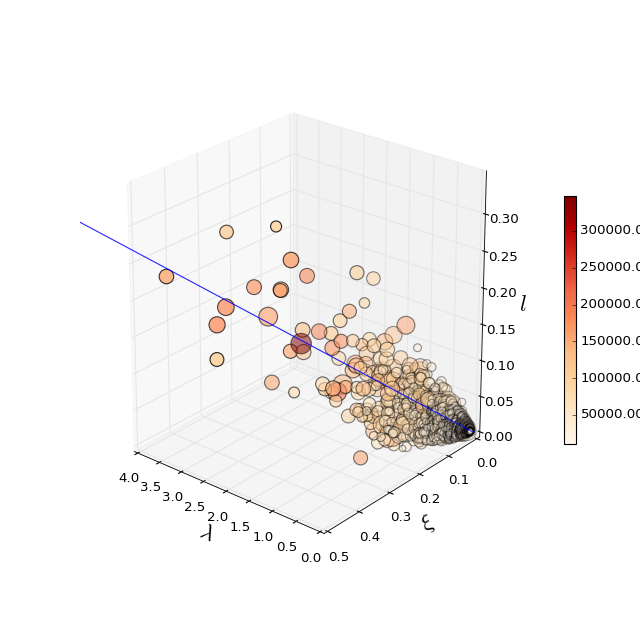

pca =  [-0.93497118 -0.31990583 -0.15326172]


In [45]:
lamb = np.array(size)[:,0]
xi   = np.array(size)[:,1]
ll   = np.array(size)[:,2]
nsheet = len(ll)

#
# try to visualize the 3d correlation
#
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare the color gradient which is used to present epsilon or jmax 
# and marker size for avg dissipation rate
cs = jmax[:nsheet]
print max(cs),min(cs)
ss = np.array(diss[:nsheet])/np.array(ncells[:nsheet])
ss = (ss/min(ss))**4*10
print max(ss),min(ss)
#nlev = 10.
#ss = min(ss)*10**(i*np.log10(max(ss)/min(ss))/nlev for i in range(10))


cNorm = matplotlib.colors.Normalize(vmin=np.min(cs), vmax=np.max(cs))
#cNorm = matplotlib.colors.LogNorm(vmin=np.min(cs), vmax=np.max(cs))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('OrRd'))
#print scalarMap.to_rgba(cs)

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=0.08
ax = fig.gca(projection='3d')


# add principle component vectors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(np.array(size)) 
print 'pca = ',pca.components_[0]
stride = np.arange(300).reshape(1,300)
v1 = -pca.components_[0].reshape(3,1).dot(stride*0.01)
xshift=0;yshift=0;zshift=0
ax.plot(v1[0,:]+xshift,v1[1,:]+yshift,zs=v1[2,:]+zshift, alpha=40)

#ax = Axes3D(fig)
ax.scatter(lamb, xi, ll,marker='o',s=ss,c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
# fiddling with the color-bar
cb=fig.colorbar(scalarMap,fraction=fraction,pad=pad,orientation='vertical',format='%.2f')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()



ax.set_xlim3d(0, 4)
ax.set_ylim3d(0, 0.5)
ax.set_zlim3d(0, 0.35) #255)

ax.set_xlabel(r'$\lambda$',size=20)
ax.set_ylabel(r'$\xi$',size=20)
ax.set_zlabel(r'$l$',size=20)
ax.view_init(elev=22, azim=130)